# Automobile data full analysis

This notebook is a simple data analysis for the Automobile dataset provided at 
https://archive.ics.uci.edu/ml/datasets/Automobile.

A full data description can be found at https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.names

## 1) Analysis Description

**Problem type**:  Regression

**Prediction Target**: normalized-losses

**Data Format**: Headerless CSV

**Missing Values Symbole**: "?"

**Features to Ignore**: 'symboling'

**Used Loss**: mean squared error (MSE)

**Used Machine Learning Algorithms**: Normal Equations, Deep Learning


## 2) Importing necessary libraries

In [301]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
import numpy as np
import os 

In [302]:
# We set seeds for reproduciability

tf.random.set_seed(1)
np.random.seed(1)

## 3) Data Loading

In [303]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data'
# download the data from given URL and with given columns
columns = ['symbolying','normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 'drive-wheels', 'engine-location'
        ,'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 'num-of-cylinders', 'engine-size', 'fuel-system'
        ,'bore', 'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']

#loading the dataset using pandas and replacing "?" with NA values
raw_data = pd.read_csv(url,names=columns,na_values="?")

#We ignore 'symboling' column
raw_data.pop('symbolying')
raw_data.head()

,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,164.0,audi,gas,std,four,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,164.0,audi,gas,std,four,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


## 3) Handling Missing Values

In [304]:
#we check NA values 
raw_data.isna().sum()

normalized-losses    41
make                  0
fuel-type             0
aspiration            0
num-of-doors          2
body-style            0
drive-wheels          0
engine-location       0
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-type           0
num-of-cylinders      0
engine-size           0
fuel-system           0
bore                  4
stroke                4
compression-ratio     0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

<font color='green'>**Observation** </font>: most of missing values are 'normalized loss' values which is our prediction target. Normally we drop rows only with missing values in the prediction target. However, the data is too small and filling input features missing values with median, mean or 0 might harm the generalization to test data. It is better to drop all rows with missing values instead.

In [305]:
dataset = raw_data.dropna().copy()

## 4) Statistics

In [306]:
# general statistics over quantitative values
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
normalized-losses,159.0,121.132075,35.651285,65.00,94.000,113.00,148.00,256.00
wheel-base,159.0,98.264151,5.167416,86.60,94.500,96.90,100.80,115.60
length,159.0,172.413836,11.523177,141.10,165.650,172.40,177.80,202.60
width,159.0,65.607547,1.947883,60.30,64.000,65.40,66.50,71.70
height,159.0,53.899371,2.268761,49.40,52.250,54.10,55.50,59.80
curb-weight,159.0,2461.138365,481.941321,1488.00,2065.500,2340.00,2809.50,4066.00
engine-size,159.0,119.226415,30.460791,61.00,97.000,110.00,135.00,258.00
bore,159.0,3.300126,0.267336,2.54,3.050,3.27,3.56,3.94
stroke,159.0,3.236352,0.294888,2.07,3.105,3.27,3.41,4.17
compression-ratio,159.0,10.161132,3.889475,7.00,8.700,9.00,9.40,23.00


<font color='green'>**Observation** </font>: We can see that the quantitative values are in different ranges. Although this has no effect when we use normal equations, it is expected to prevent or delay the convergence when we use neural networks. Therefore we perform a Min-Max normalization over quantitative input features

In [307]:
#first we make a copy of un normalized dataset to use it later with the normal equation model
unnormed_dataset = dataset.copy()
# we perform min-max normalization as the following
norm_data = dataset.loc[:,["wheel-base","length","width","height","curb-weight","engine-size","bore","stroke","compression-ratio","horsepower","peak-rpm","city-mpg","highway-mpg","price"]].copy()
norm_data_mins = norm_data.min()
norm_data_maxs = norm_data.max()
normalized_features =(norm_data-norm_data_mins)/(norm_data_maxs -  norm_data_mins)
dataset.loc[:,["wheel-base","length","width","height","curb-weight","engine-size","bore","stroke","compression-ratio","horsepower","peak-rpm","city-mpg","highway-mpg","price"]] = normalized_features.loc[:,["wheel-base","length","width","height","curb-weight","engine-size","bore","stroke","compression-ratio","horsepower","peak-rpm","city-mpg","highway-mpg","price"]]

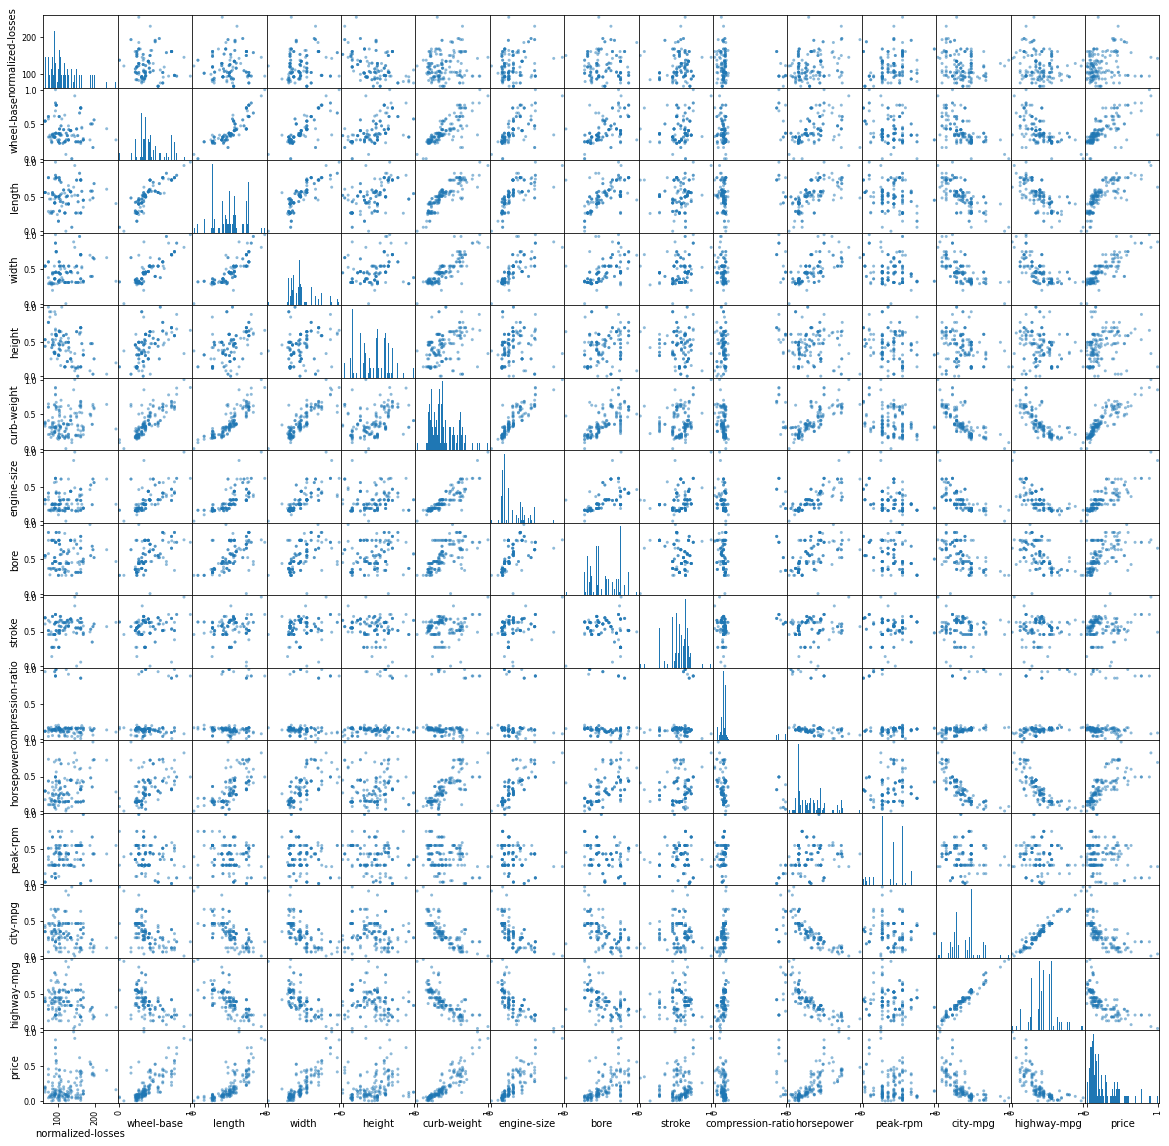

In [308]:
# Now we can generate a scatter plot for quantitative values
pd.plotting.scatter_matrix(dataset.drop(columns=["make","fuel-type","aspiration","num-of-doors","body-style","drive-wheels"
                                ,"engine-location","num-of-cylinders","engine-type","fuel-system"]),
                           hist_kwds={'bins': 100},figsize=(20,20));

<font color='green'>**Observation** </font>: 
* We can observe the existance of outliers in the prediction target (normalized-losses). which might indicate that using a mean absolute error (MAE) might be better than using a mean squared error (MSE) loss function.<font color='red'> However, it was required to use MSE for this task so we will go with it</font>.

* We also observe a weak correlation between the target and features except with the 'hight' feature where we can see a relativly stronger negative correlation.*
* "highway-mpg" and "city-mpg" are highly correlated features, we might need to break this correlation.

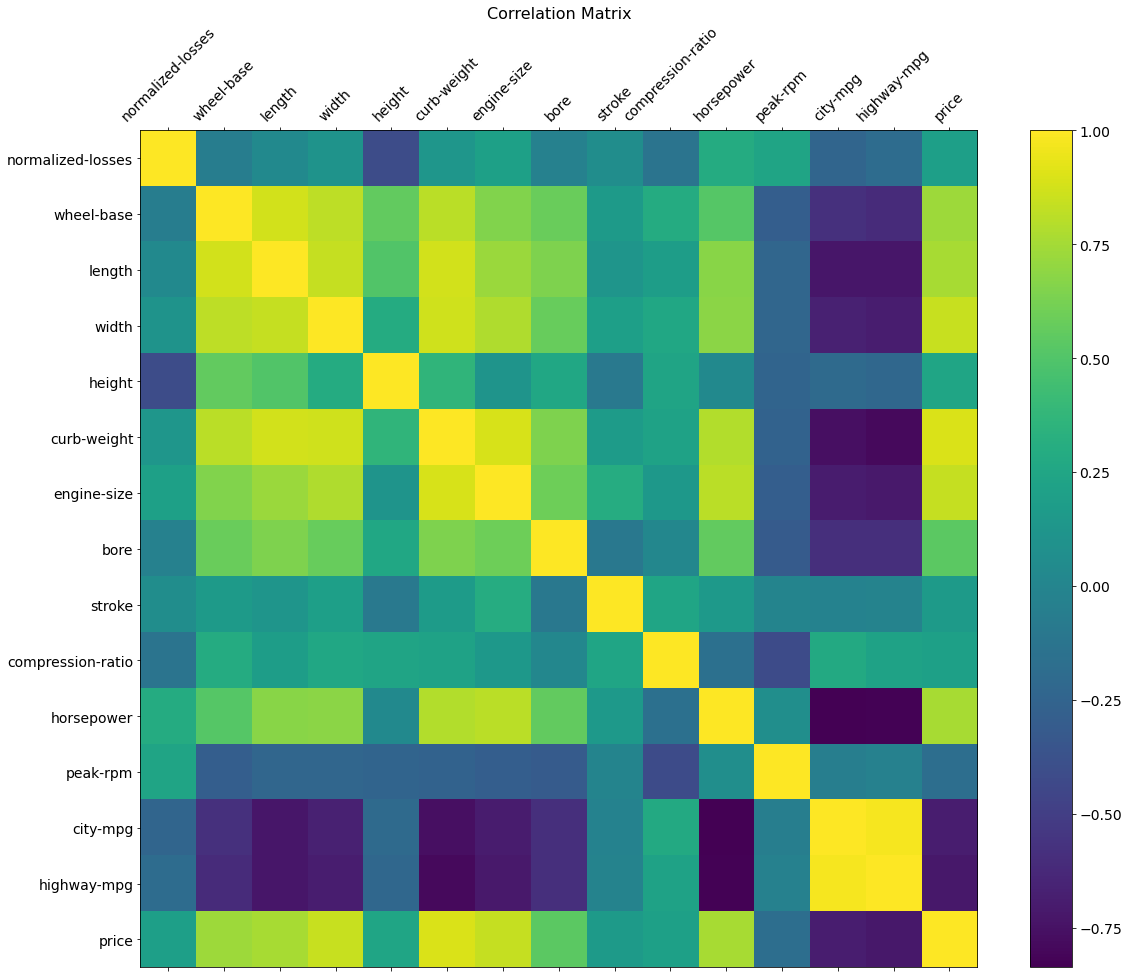

In [309]:
# Let's confirm by plotting the correlation matrix
f = plt.figure(figsize=(19, 15))
plt.matshow(dataset.corr(), fignum=f.number)
plt.xticks(range(dataset.select_dtypes(['number']).shape[1]), dataset.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(dataset.select_dtypes(['number']).shape[1]), dataset.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

<font color='green'>**Observation** </font>:  Normally we would merge "city-mpg" and "highway-mpg" since they are highly correlated. but test results showed that they are better kept separate. 

## 5) Handling Categorical Features

First, we check the state of class counts per categorical feature

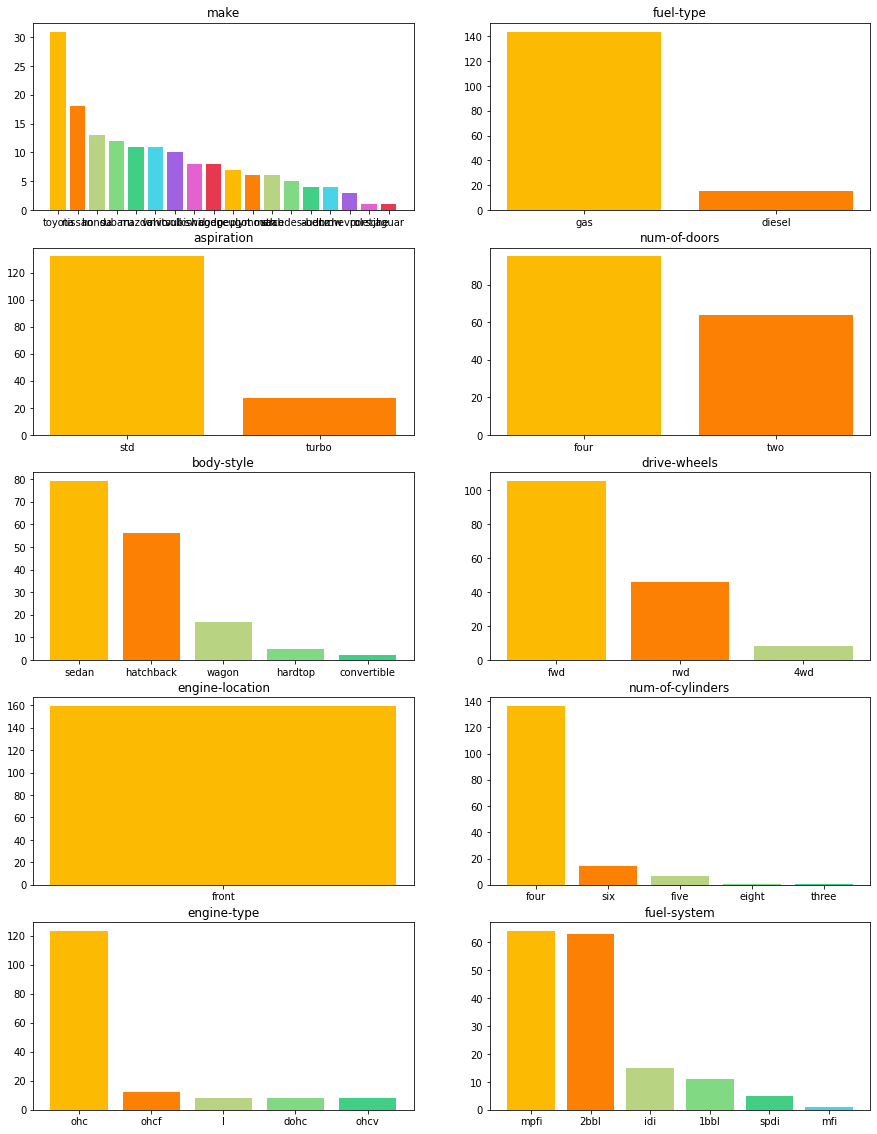

In [310]:
fig_colors = ["#fcba03","#fc8003","#b8d483","#82d983","#40cf85","#49d3e6", "#a062e3", "#e362d0","#e63950"]
fig, axs = plt.subplots(5, 2,figsize=(15,20))
category_features = ["make","fuel-type","aspiration","num-of-doors","body-style","drive-wheels"
                                ,"engine-location","num-of-cylinders","engine-type","fuel-system"]
for i,column_name in enumerate(category_features):
    axs[int(i/2),i%2].set_title(column_name)
    axs[int(i/2),i%2].bar(dataset[column_name].value_counts().keys(),dataset[column_name].value_counts(),color=fig_colors)

<font color='green'>**Observation** </font>:  We can see that classes per each categorical feature are highly imbalanced. Unfortunately, the data is not large enough to fix the imbalance is a smart way. and ***fixing it with a naive approach (replicating minority classes) did not help much***

***Now we assign a one-hot encoding for eatch categorical feature***

In [311]:
dataset = pd.get_dummies(dataset,columns=["num-of-cylinders","num-of-doors","make","fuel-type","aspiration","body-style","drive-wheels"
                        ,"engine-location","engine-type","fuel-system"],
                        prefix=["num-of-cylinders","num-of-doors","make","fuel-type","aspiration","body-style","drive-wheels"
                        ,"engine-location","engine-type","fuel-system"],prefix_sep='_')

unnormed_dataset = pd.get_dummies(unnormed_dataset,columns=["num-of-cylinders","num-of-doors","make","fuel-type","aspiration","body-style","drive-wheels"
                        ,"engine-location","engine-type","fuel-system"],
                        prefix=["num-of-cylinders","num-of-doors","make","fuel-type","aspiration","body-style","drive-wheels"
                        ,"engine-location","engine-type","fuel-system"],prefix_sep='_')

## 6) Target Prediction 

### a) Using Normal Equations

A normal equation solution is great for problems with such datasets with small number of features and examples

First, let's devide train and test sets. We ignore validation set due to small number of examples

In [312]:
# We set 80% of the available data for training and the rest for testing
train_dataset = unnormed_dataset.sample(frac = 0.8, random_state=0)
test_dataset = unnormed_dataset.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('normalized-losses')
test_labels = test_features.pop('normalized-losses')

<font color='green'>**Observation and a trick** </font>: since our target variable is always positive, we can log scale it and exponentiate after prediction. it works well with regression models.

In [313]:
log_labels = np.log(train_labels)

In [314]:
#first we get the identity matrix
identity_size = train_features.shape[1]
identity_matrix= np.zeros((identity_size, identity_size))
np.fill_diagonal(identity_matrix, 1)

# we set a regularization parameter labmda to 1
lamb = 1
xTx = train_features.T.dot(train_features) + lamb * identity_matrix
xTx_inv = np.linalg.inv(xTx)
xTx_inv_xT = xTx_inv.dot(train_features.T)
theta = xTx_inv_xT.dot(log_labels)


Okay, now since we have our *theta* lets test our model

<font color='red'>**Remember** </font>: since we took the log of the lables, we must exponentiate after each prediction

In [315]:

prediction = np.exp(test_features.dot(theta))
mse = (np.square(prediction - test_labels)).mean()
percentage = np.mean(np.abs(prediction - test_labels)/(test_labels))
print("mean squared error is {} and the percentage is {}".format(mse,percentage))

mean squared error is 278.9966471058905 and the percentage is 0.11754073924291711


<font color='red'>**Results** </font>: **Our normal equation model achieved a mean squared error of 279.0 (16.67 RMSE) and a percentage Error of 11.75%.**

Let's plot the predicted vs real labels of the test dataset

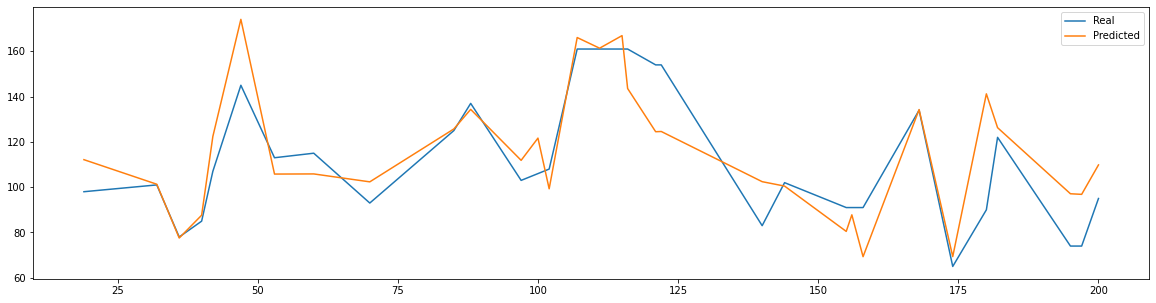

In [316]:
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(test_labels)
plt.plot(prediction)
plt.legend(["Real","Predicted"])
plt.show()

### b) Using Neural Networks

Although deep neural network are extremly powerfull we do not expect to take advantage of that power due to small sample size. 

In [317]:
# We set 80% of the available data for training and the rest for testing
train_dataset = dataset.sample(frac = 0.8, random_state=1)
test_dataset = dataset.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('normalized-losses')
test_labels = test_features.pop('normalized-losses')
# Working with such small dataset, it is better to train the model sample by sample for it to converge quickly
batch_size = 1
train_ds = tf.data.Dataset.from_tensor_slices((np.array(train_features),np.log(np.array(train_labels)))).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((np.array(test_features),np.log(np.array(test_labels)))).batch(batch_size)

Now, we define a simple 3 hidden layers deep neural network model with relu activation functions.

In [318]:
class Regression_Model(Model):

    def __init__(self):
        super(Regression_Model,self).__init__()
        self.dense1 = Dense(64, activation='relu' )
        self.dense2 = Dense(32, activation='relu' )
        self.dense3 = Dense(16, activation='relu' )
        self.final = Dense(1)


    def call(self,x):
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return self.final(x)


After that, let's define a Trainer class that incapsulates all out training related operations

In [319]:
class Trainer:

    def __init__(self):
        self.model:Regression_Model = Regression_Model()
        
        self.loss = self.get_loss()
        self.optimizer = self.get_optimizer("SGD")
        self.train_loss = tf.keras.metrics.Mean(name='train_loss')
        self.test_loss = tf.keras.metrics.Mean(name='test_loss')


    def get_optimizer(self,opt="adam"):
        lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(0.1,decay_steps=10000,decay_rate=1,staircase=False)
        if opt == 'adam':
            return tf.keras.optimizers.Adam(0.001)
        elif opt == 'SGD':
            return tf.keras.optimizers.SGD(lr_schedule)
        else:
            raise "This optimizer does not exist"

    def get_loss(self,loss='MSE'):
        if loss == 'MSE':
            return tf.keras.losses.MSE
        if loss == 'MAE':
            return tf.keras.losses.MAE
        else:
            raise "error"
    def predict(self,features):
        return self.model.predict(features)

    @tf.function
    def train_step(self,features,values):
        with tf.GradientTape() as tape:
            predictions = self.model(features,training = True)
            loss = self.loss(values,predictions)
            gradients = tape.gradient(loss,self.model.trainable_variables)
            self.optimizer.apply_gradients(zip(gradients,self.model.trainable_variables))
            self.train_loss(loss)
    
    @tf.function
    def test_step(self,features,values):
        predictions = self.model(features,training=False)
        loss = self.loss(values,predictions)
        self.test_loss(loss)

    def train(self):
        
        for epoch in range(100):
            self.train_loss.reset_states()
            self.test_loss.reset_states()

            for features,values in train_ds:
                self.train_step(features,values)

            for features,values in test_ds:
                self.test_step(features,values)
            
            print(
                f'Epoch {epoch + 1}, '
                f'Loss: {self.train_loss.result()}, '
                f'Test Loss: {self.test_loss.result()}, '
            )
        

In [320]:
# Now we reset the random seeds for reproduciability and start the training!
os.environ['PYTHONHASHSEED']=str(1)
tf.random.set_seed(1)
np.random.seed(1)
trainer = Trainer()
trainer.train()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 0.6960877776145935, Test Loss: 0.06503190845251083, 
Epoch 2, Loss: 0.05881175026297569, Test Loss: 0.06284657120704651, 
Epoch 3, Loss: 0.035339564085006714, Test Loss: 0.04167012497782707, 
Epoch 4, Loss: 0.02654873952269554, Test Loss: 0.03282739594578743, 
Epoch 5, Loss: 0.021178744733333588, Test Loss: 0.029000714421272278, 
Epoch 6, Loss: 0.01668511889874935, Test Loss: 0.02898460067808628, 
Epoch 7, Loss: 0.013567658141255379, Test Loss: 0.02576357126235962, 
Epoch 8, Loss: 0.01216

In [321]:
# lets see th esummary of the trained model
trainer.model.summary()

Model: "regression__model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             multiple                  4096      
_________________________________________________________________
dense_41 (Dense)             multiple                  2080      
_________________________________________________________________
dense_42 (Dense)             multiple                  528       
_________________________________________________________________
dense_43 (Dense)             multiple                  17        
Total params: 6,721
Trainable params: 6,721
Non-trainable params: 0
_________________________________________________________________


Okay,lets test our model on the test dataset

<font color='red'>**Remember** </font>: since we took the log of the lables, we must exponentiate after each prediction

In [322]:
# Now we test the model on the test set
predictions = np.exp(np.reshape(trainer.model.predict(np.array(test_features)),(np.shape(test_features)[0],)))
mse = (np.square(predictions - test_labels)).mean()
percentage = np.mean(np.abs(predictions - test_labels)/(test_labels))
print("mean squared error is {} and the percentage is {}".format(mse,percentage))


mean squared error is 226.68014657294407 and the percentage is 0.09351119276733072


<font color='red'>**Results** </font>: **Our deep neural ntwork model achieved a mean squared error of 226.68 (15.05 RMSE) and a percentage Error of 9.35%.**

Let's plot the predicted vs real labels of the test dataset

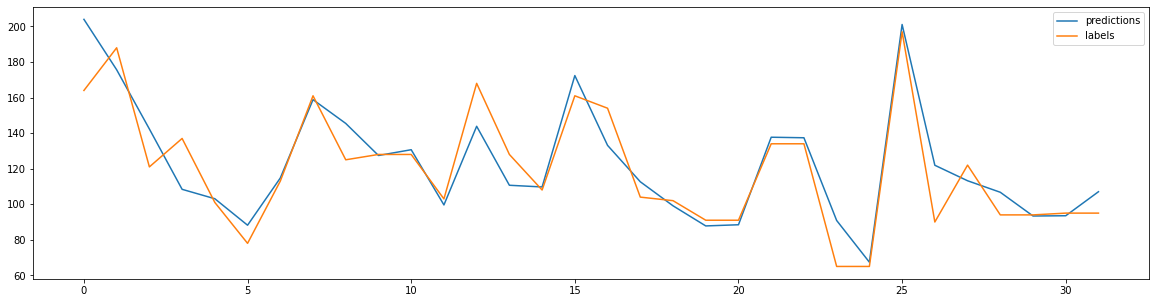

In [323]:
plt.plot(predictions)
plt.plot(np.array(test_labels))
plt.legend(labels = ["predictions","labels"])
plt.show()

## 7) Final results and Conclusion

<table>
    <tr>
        <td><b>Algorithm</b></td>
        <td><b>MSE</b></td>
        <td><b>RMSE</b></td>
        <td><b>Percentage Error</b></td>
    </tr>
        <tr>
        <td><b>Normal Equations</b></td>
        <td>279.0</td>
        <td>16.67</td>
        <td>11.75%</td>
    </tr>
        <tr>
        <td><b>Neural Networks</b></td>
        <td>226.68 </td>
        <td>15.05</td>
        <td>9.35%</td>
    </tr>
</table>

Even with such small dataset. a neural network model could still outperform a normal equations model by a small margin. However, with larger data is is exected that the DNN would outperform by a landslide.